# Spatial and temporal analysis of greenhouse gas emissions transfers over the US electric grid

##### Guangyu Cai, Joe Franke, Amina Jackson, Jenni Nugent 


### Research Questions

1. How is electricity transferred on the U.S. electric grid between balancing authorities on a sub-annual timescale?
2. What is the spatial distribution of emissions and how does it compare to median household income?

### Project Motivation

- Spatial and temporal transfer of resources has important policy and environmental justice implications.
 

### Data Sources

- **U.S. Energy Information Administration**
    - `Form EIA-923`
        - URL: https://www.eia.gov/electricity/data/eia923/
        - Includes:
            - Plant-level fuel type
            - Monthly plant-level fuel consumption and electricity generation
    - `Form EIA-860`
        - URL: https://www.eia.gov/electricity/data/eia860/
        - Includes:
            - Power plant location (latitude and longitude)
            - Power plant balancing authority
    - `Form EIA-930`
        - URL: https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48?src=email
        - Includes: 
            - Hourly electric transfers between balancing authorities
- **Homeland Infrastructure Foundation-Level Data (HIFLD)**
    - `Control Areas` (Balancing Authority Shapefiles)
        - https://hifld-geoplatform.opendata.arcgis.com/search?q=control%20areas
- **U.S. Environmental Protection Agency**
    - `Greenhouse Gas Emissions Factors`
        - URL: https://www.epa.gov/climateleadership/ghg-emission-factors-hub
- **U.S. Census Bureau**
    - `Median Household Income` by tract (2018)
        - URL: https://data.census.gov/cedsci/table?q=median%20household%20income%202020&tid=ACSST5Y2020.S1901
    - `Census Tracts` (2018) shapefiles
        - URL: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

### Workflow Overview

- Import Packages
- U.S. Energy Information Administration Data Preparation
- Greenhouse Gas Emissions Estimate
- Data Preparation
    - Data Preparation Visualization 1: Balancing Authority Data
    - Data Preparation Visualization 2: Emissions and Location Dataframe
    - Data Preparation Visualization 3: Emissions and Fuel Type Dataframe
    - Data Preparation Visualization 3: Census Data Preparation
- Visualizations
    - Visualization 1: Map of BA-to-BA electric transfers
    - Visualization 2: Map of Point Source GHG Emissions
    - Visualization 3: Map of Power Plants & Fuel Type and Median Household Income


### Import Packages

In [45]:
import pandas as pd
import math
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
#pakages needed to add
import networkx as nx
import geoplot as gplt
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
import mapclassify
import plotly.express as px
import contextily as cx

#the pakages needed using conda
#conda install -c conda-forge geoplot
#conda install pysal
#conda install -c conda-forge pyvis

### U.S. Energy Information Administration Data Preparation

- Import power plant location and balancing authority data from EIA-860
- Import plant-level fuel type, fuel consumption, and electricity generation data from EIA-923
    - Transform monthly data from wide format to long format

In [3]:
# Import plant location data from Form EIA-860
plantData_2018 = pd.read_csv('./EIA Data/2___Plant_Y2018.csv',header=1)
keep_columns1 = (['Plant Code','Latitude',
                  'Longitude','Balancing Authority Code'])
plantData_2018 = plantData_2018[keep_columns1] 
plantData_2018.head()

,Plant Code,Latitude,Longitude,Balancing Authority Code
0,2,33.458665,-87.356823,SOCO
1,3,31.006900,-88.010300,SOCO
2,4,32.583889,-86.283056,SOCO
3,7,34.012800,-85.970800,SOCO
4,8,33.644344,-87.196486,SOCO


In [4]:
# Import monthly, plant-level fuel cosnumption and generation data from Form EIA-923
fuelAndGeneration_2018 = pd.read_csv('./EIA Data/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.csv',header=5)
fuelAndGeneration_2018.rename(columns = {'Plant Id': 'Plant ID',
                                         'Combined Heat And\nPower Plant': 'Combined Heat & Power Plant',
                                         'Plant State': 'State',
                                         'Reported\nPrime Mover': 'Reported Prime Mover', 
                                         'Reported\nFuel Type Code':'Reported Fuel Type Code',
                                         'Elec_MMBtu\nJanuary': 'Elec_MMBtu_Jan', 
                                         'Elec_MMBtu\nFebruary': 'Elec_MMBtu_Feb', 
                                         'Elec_MMBtu\nMarch': 'Elec_MMBtu_Mar',
                                         'Elec_MMBtu\nApril': 'Elec_MMBtu_Apr', 
                                         'Elec_MMBtu\nMay': 'Elec_MMBtu_May', 
                                         'Elec_MMBtu\nJune': 'Elec_MMBtu_Jun',
                                         'Elec_MMBtu\nJuly': 'Elec_MMBtu_Jul', 
                                         'Elec_MMBtu\nAugust': 'Elec_MMBtu_Aug', 
                                         'Elec_MMBtu\nSeptember': 'Elec_MMBtu_Sep',
                                         'Elec_MMBtu\nOctober': 'Elec_MMBtu_Oct', 
                                         'Elec_MMBtu\nNovember': 'Elec_MMBtu_Nov', 
                                         'Elec_MMBtu\nDecember': 'Elec_MMBtu_Dec',
                                         'Netgen\nJanuary':'Netgen_Jan', 
                                         'Netgen\nFebruary':'Netgen_Feb', 
                                         'Netgen\nMarch':'Netgen_Mar',
                                         'Netgen\nApril':'Netgen_Apr',
                                         'Netgen\nMay':'Netgen_May', 
                                         'Netgen\nJune':'Netgen_Jun', 
                                         'Netgen\nJuly':'Netgen_Jul', 
                                         'Netgen\nAugust':'Netgen_Aug',
                                         'Netgen\nSeptember':'Netgen_Sep', 
                                         'Netgen\nOctober':'Netgen_Oct', 
                                         'Netgen\nNovember':'Netgen_Nov', 
                                         'Netgen\nDecember':'Netgen_Dec'}, inplace = True) 

In [5]:
# Create a function that converts strings to floats in EIA-923 Files
def string2Float(dfRow):
    if type(dfRow) == str:
        if dfRow == '.': #replace missing values with 0
            x = 0
        elif dfRow == 'nan': #replace missing values with 0
            x = 0
        else:
            x = float(dfRow.replace(',','')) #remove commas from values and convert to float type
    if type(dfRow) == float:
        if math.isnan(dfRow): #replace missing values with 0
            x = 0
        else:
            x = dfRow
    return x

In [6]:
# Convert String Numbers to Float Values
convert_columns = (['Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                    'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                    'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec',
                    'Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                    'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                    'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec'])
for col in convert_columns:
    fuelAndGeneration_2018[col] = fuelAndGeneration_2018.apply(lambda row: string2Float(row[col]),axis=1)
#fuelAndGeneration_2018

In [7]:
# Keep generation data and create dataframe of generation
keep_columns2 = (['Plant ID', 'Combined Heat & Power Plant', 'Plant Name',
                 'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code',
                 'Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                 'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                 'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec'])
generation_2018 = fuelAndGeneration_2018[keep_columns2] 

In [8]:
# Keep fuel consumption data and create dataframe of fuel consumption
keep_columns3 = (['Plant ID', 'Combined Heat & Power Plant', 'Plant Name',
                 'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code',
                 'Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                 'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                 'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec'])
fuel_2018 = fuelAndGeneration_2018[keep_columns3] 

In [9]:
# Melt generation data from wide to long format
genMonthsList = ['Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                 'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                 'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec']
monthNum1 = list(range(1, 13))
genMonths = dict(zip(genMonthsList,monthNum1))
netGenMelted = generation_2018.melt(id_vars=['Plant ID', 'Combined Heat & Power Plant', 'Plant Name', 
                                'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code'], 
                                 value_vars=genMonthsList, 
                                 value_name='Net Generation (MWh)',
                                 var_name= 'Month')
generation_2018 = netGenMelted.assign(Month=netGenMelted['Month'].map(genMonths)) 
#generation_2018

In [10]:
#Melt fuel consumption from wide to long format
fuelMonthsList = ['Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                 'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                 'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec']
monthNum1 = list(range(1, 13))
fuelMonths = dict(zip(fuelMonthsList,monthNum1))
fuelMelted = fuel_2018.melt(id_vars=['Plant ID', 'Combined Heat & Power Plant', 'Plant Name', 
                                'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code'], 
                                 value_vars=fuelMonthsList, 
                                 value_name='Electric Fuel Consumption (MMBtu)',
                                 var_name= 'Month')
fuel_2018 = fuelMelted.assign(Month=fuelMelted['Month'].map(fuelMonths)) 
#fuel_2018

In [11]:
# Merge long-format fuel data and long-format generation data
fuelAndGeneration_2018long =  fuel_2018.copy()
fuelAndGeneration_2018long['Net Generation (MWh)'] =  generation_2018['Net Generation (MWh)']
#fuelAndGeneration_2018long.to_csv('fuelAndGeneration_2018long1.csv')
fuelAndGeneration_2018long.head()

,Plant ID,Combined Heat & Power Plant,Plant Name,State,NERC Region,Reported Prime Mover,Reported Fuel Type Code,Month,Electric Fuel Consumption (MMBtu),Net Generation (MWh)
0,2,N,Bankhead Dam,AL,SERC,HY,WAT,1,0.0,-36.0
1,3,N,Barry,AL,SERC,CA,NG,1,56603.0,264566.0
2,3,N,Barry,AL,SERC,CT,NG,1,5202919.0,493620.0
3,3,N,Barry,AL,SERC,CT,SUB,1,0.0,0.0
4,3,N,Barry,AL,SERC,ST,BIT,1,4770781.0,474858.0


### Greenhouse Gas Emissions Estimate

- Estimate GHG emissions based on EIA-923 fuel consumption data and emissions factors from the EPA

In [12]:
# Create Function for Estimating GHG emissions
def GHG_estimate(fuelType,fuelConsumption,netGeneration):
    CH4_GWP = 25
    N2O_GWP = 298
    G_TO_KG = 1/1000
    KG_TO_LBS = 1/2.204623  
    
    if fuelType == "NG": 
        """Natural Gas"""
        CO2eqv = 53.06 + 1.0*CH4_GWP*G_TO_KG + 0.10*N2O_GWP*G_TO_KG

    elif fuelType == "ANT": 
        """Anthracite Coal"""
        CO2eqv = 103.69 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "BIT": 
        """Bituminous Coal"""
        CO2eqv = 93.28 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "LIG": 
        """Lignite Coal"""
        CO2eqv = 97.72 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "SUB": 
        """Sub-bituminous Coal"""
        CO2eqv = 97.17 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    
    elif fuelType == "JF": 
        """Jet Fuel [Kerosene-Type Jet Fuel]"""
        CO2eqv = 72.22 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG
    elif fuelType == "PG": 
        """Propane Gas"""
        CO2eqv = 61.46 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG
    elif fuelType == "PC": 
        """Petroleum Coke - [Solid]"""
        CO2eqv = 102.41 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG     
    elif fuelType == "WDS": 
        """Wood/Wood Waste Solids [Wood and Wood Residuals]"""            
        CO2eqv = 93.80 + 7.2*CH4_GWP*G_TO_KG + 3.6*N2O_GWP*G_TO_KG 
    elif fuelType == "KER": 
        """Kerosene"""
        CO2eqv = 75.20 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG 
    elif fuelType == "DFO": 
        """Distillate Fuel Oil (including diesel, No. 1, No. 2, and No. 4 fuel oils) [No. 1, No. 2, No. 3]"""
        tempCO2 = (73.25 + 73.96 + 75.04)/3 #Average No.1, No.2, No.4
        CO2eqv = tempCO2 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG  
    elif fuelType == "LFG": 
        """Landfill Gas"""
        CO2eqv = 52.07 + 3.2*CH4_GWP*G_TO_KG + 0.63*N2O_GWP*G_TO_KG 
    elif fuelType == "AB": 
        """Agricultural By-Products"""
        CO2eqv = 118.17 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG 
    elif fuelType == "RFO": 
        """Residual Fuel Oil (incl. Nos. 5 & 6 fuel oils, and bunker C fuel oil) [No. 5, No.6]"""
        tempCO2 = (72.93 + 75.10)/2 #Average No.5, No.6
        CO2eqv = tempCO2 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG 
    elif fuelType == "TDF": 
        """Tire-Derived Fuels [Tires]"""
        CO2eqv = 85.97 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG  
    elif fuelType == "OBG": 
        """Other Biomass Gas"""
        CO2eqv = 52.07 + 3.2*CH4_GWP*G_TO_KG + 0.63*N2O_GWP*G_TO_KG 
    else:                
        CO2eqv = 0
    
    GHG = (CO2eqv * fuelConsumption) * KG_TO_LBS # ((kg/MMbtu) * MMBtu) 
    return round(GHG, 4)

In [13]:
# Estimate GHG Emissions
fuelAndGeneration_2018long['GHG Estimate (lbs)'] = fuelAndGeneration_2018long.apply(lambda row: GHG_estimate(row['Reported Fuel Type Code'],row['Electric Fuel Consumption (MMBtu)'],row['Net Generation (MWh)']),axis=1)
fuelAndGeneration_2018long = fuelAndGeneration_2018long[ fuelAndGeneration_2018long['GHG Estimate (lbs)'] > 0 ] 
#fuelAndGeneration_2018long.to_csv('fuelAndGeneration_2018long.csv')
#fuelAndGeneration_2018long

In [14]:
# Aggregate GHG Emissions by plant
fuelAndGeneration_2018_AggPlant = fuelAndGeneration_2018long.groupby(by = ['Month','Plant ID'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                    'Net Generation (MWh)': ['sum']})

fuelAndGeneration_2018_AggPlant.columns = fuelAndGeneration_2018_AggPlant.columns.droplevel(1)
fuelAndGeneration_2018_AggPlant.head()

,Month,Plant ID,GHG Estimate (lbs),Net Generation (MWh)
0,1,3,3.385828e+08,1267682.0
1,1,7,4.145301e+06,14592.0
2,1,8,2.683336e+08,665047.0
3,1,9,1.432610e+06,3601.0
4,1,10,2.123426e+07,72463.0


### Data Preparation Visualization 1: Balancing Authority Data

- Match Balancing Authority Acronyms with Balancing authority shapefiles
- Find the centroid of the balancing authorities
- Import electricty transfer data between balancing authorities

In [15]:
# Import Balancing Authority Shape Data
balancing_Authorities = gpd.read_file('./BA Geometry/Control_Areas.geojson')
balancing_Authorities = balancing_Authorities.set_index('OBJECTID')
balancing_Authorities = balancing_Authorities[(balancing_Authorities['STATE'] != 'AK') & (balancing_Authorities['STATE'] != 'HI' )]
#print(balancing_Authorities.crs)

In [16]:
# Import Balacing Authority Acronym List
BA_Acronyms = pd.read_csv('./BA Geometry/Balancing Authorities EIA930 HIFDL 2018.csv')
BA_Acronyms

# Merge Balancing Authority Shape Data with Acronyms
BA_Acronyms = balancing_Authorities.merge(BA_Acronyms, left_on='NAME', right_on='HIFDL Name 2022', how='right')
BA_Acronyms = BA_Acronyms[['BA Code', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'geometry', 'Lat', 'Long']]

# Projection
BA_Acronyms_3857 = BA_Acronyms.to_crs(epsg=3857)

# Find centroids
BA_Acronyms_3857['centroid'] = BA_Acronyms_3857.centroid

In [36]:
BA_Acronyms_3857['polygon'] = BA_Acronyms_3857['geometry']

BA_Acronyms_3857['geometry'] = BA_Acronyms_3857['centroid']
BA_Acronyms_3857.head()

,BA Code,NAME,ADDRESS,CITY,STATE,ZIP,geometry,Lat,Long,centroid,polygon
0,AEC,POWERSOUTH ENERGY COOPERATIVE,2027 EAST THREE NOTCH STREET,ANDALUSIA,AL,36421,POINT (-9611030.709 3729510.804),NaN,NaN,POINT (-9611030.709 3729510.804),"MULTIPOLYGON (((-9742651.778 3539981.548, -974..."
1,AECI,"ASSOCIATED ELECTRIC COOPERATIVE, INC.",2814 S GOLDEN AVE,SPRINGFIELD,MO,65807,POINT (-10358940.507 4601289.142),NaN,NaN,POINT (-10358940.507 4601289.142),"MULTIPOLYGON (((-10074508.538 4224075.067, -10..."
2,AVA,AVISTA CORPORATION,1411 EAST MISSION AVENUE,SPOKANE,WA,99220,POINT (-13014863.554 5952876.520),NaN,NaN,POINT (-13014863.554 5952876.520),"MULTIPOLYGON (((-13063826.484 6274913.995, -13..."
3,AVRN,AVANGRID RENEWABLES LLC,"1125 NW COUCH ST., SUITE 700",PORTLAND,OR,97209,POINT (-13444729.595 5393305.285),NaN,NaN,POINT (-13444729.595 5393305.285),"MULTIPOLYGON (((-13467963.213 5406452.355, -13..."
4,AZPS,ARIZONA PUBLIC SERVICE COMPANY,MS # 9997,PHOENIX,AZ,85072,POINT (-12474930.473 3993335.322),NaN,NaN,POINT (-12474930.473 3993335.322),"MULTIPOLYGON (((-12165073.555 3702720.955, -12..."


In [37]:
BA_Acronyms_3857 = BA_Acronyms_3857.set_geometry('centroid')
BA_Acronyms_3857.head()

,BA Code,NAME,ADDRESS,CITY,STATE,ZIP,geometry,Lat,Long,centroid,polygon
0,AEC,POWERSOUTH ENERGY COOPERATIVE,2027 EAST THREE NOTCH STREET,ANDALUSIA,AL,36421,POINT (-9611030.709 3729510.804),NaN,NaN,POINT (-9611030.709 3729510.804),"MULTIPOLYGON (((-9742651.778 3539981.548, -974..."
1,AECI,"ASSOCIATED ELECTRIC COOPERATIVE, INC.",2814 S GOLDEN AVE,SPRINGFIELD,MO,65807,POINT (-10358940.507 4601289.142),NaN,NaN,POINT (-10358940.507 4601289.142),"MULTIPOLYGON (((-10074508.538 4224075.067, -10..."
2,AVA,AVISTA CORPORATION,1411 EAST MISSION AVENUE,SPOKANE,WA,99220,POINT (-13014863.554 5952876.520),NaN,NaN,POINT (-13014863.554 5952876.520),"MULTIPOLYGON (((-13063826.484 6274913.995, -13..."
3,AVRN,AVANGRID RENEWABLES LLC,"1125 NW COUCH ST., SUITE 700",PORTLAND,OR,97209,POINT (-13444729.595 5393305.285),NaN,NaN,POINT (-13444729.595 5393305.285),"MULTIPOLYGON (((-13467963.213 5406452.355, -13..."
4,AZPS,ARIZONA PUBLIC SERVICE COMPANY,MS # 9997,PHOENIX,AZ,85072,POINT (-12474930.473 3993335.322),NaN,NaN,POINT (-12474930.473 3993335.322),"MULTIPOLYGON (((-12165073.555 3702720.955, -12..."


In [17]:
#Import electricity transfer data
transferData_2018 = pd.read_csv('./Transfer Data/Total.Monthly.Transfers 2018 4.6.2022.csv')
transferData_2018.head()

,origin,destination,Year,Month,monthlyTransferMWh
0,AEC,MISO,2018,1,119447
1,AEC,MISO,2018,2,67662
2,AEC,MISO,2018,3,41530
3,AEC,MISO,2018,4,30003
4,AEC,MISO,2018,5,50136


In [38]:
#import the us state data
usa_state = gpd.read_file('./State Data/tl_2020_us_state.shp')
#change the geoid column into int type
usa_state['GEOID'] = usa_state['GEOID'].astype(int)
usa_state.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266296765,489206049,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138958484319,45975808217,+28.3989775,-082.5143005,"MULTIPOLYGON (((-86.39964 30.22696, -86.40262 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778461053,6216594318,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677759219,1323691129,+41.5964850,-071.5264901,"MULTIPOLYGON (((-71.78970 41.72520, -71.78971 ..."
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,214049923496,2391577745,+44.3484222,-114.5588538,"POLYGON ((-116.89971 44.84061, -116.89967 44.8..."
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,23190113978,1025973001,+43.6726907,-071.5843145,"POLYGON ((-72.32990 43.60021, -72.32984 43.600..."
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,125933025759,13456395178,+35.5397100,-079.1308636,"POLYGON ((-82.41674 36.07283, -82.41660 36.073..."
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,23873081385,1030243281,+44.0589536,-072.6710173,"POLYGON ((-73.31328 44.26413, -73.31274 44.265..."


In [39]:
#change the state data coordinate reference system to EPSG3857
usa_state = usa_state.to_crs("EPSG:3857")

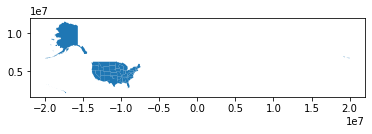

In [40]:
#only select the regions of US that we want to look into
usa_state['REGION'].unique()
usa_state.loc[usa_state['REGION'] != '9'].plot()
base = usa_state.loc[(usa_state['NAME'] != 'Hawaii') & (usa_state['NAME'] != 'Alaska') & (usa_state['REGION'] != '9')]

## Visualization 1:  Map of BA-to-BA electric transfers

- How is electricity, and subsequently embedded resources and emissions, transferred around the U.S.?

C:\Users\jenni\.conda\envs\geog489\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


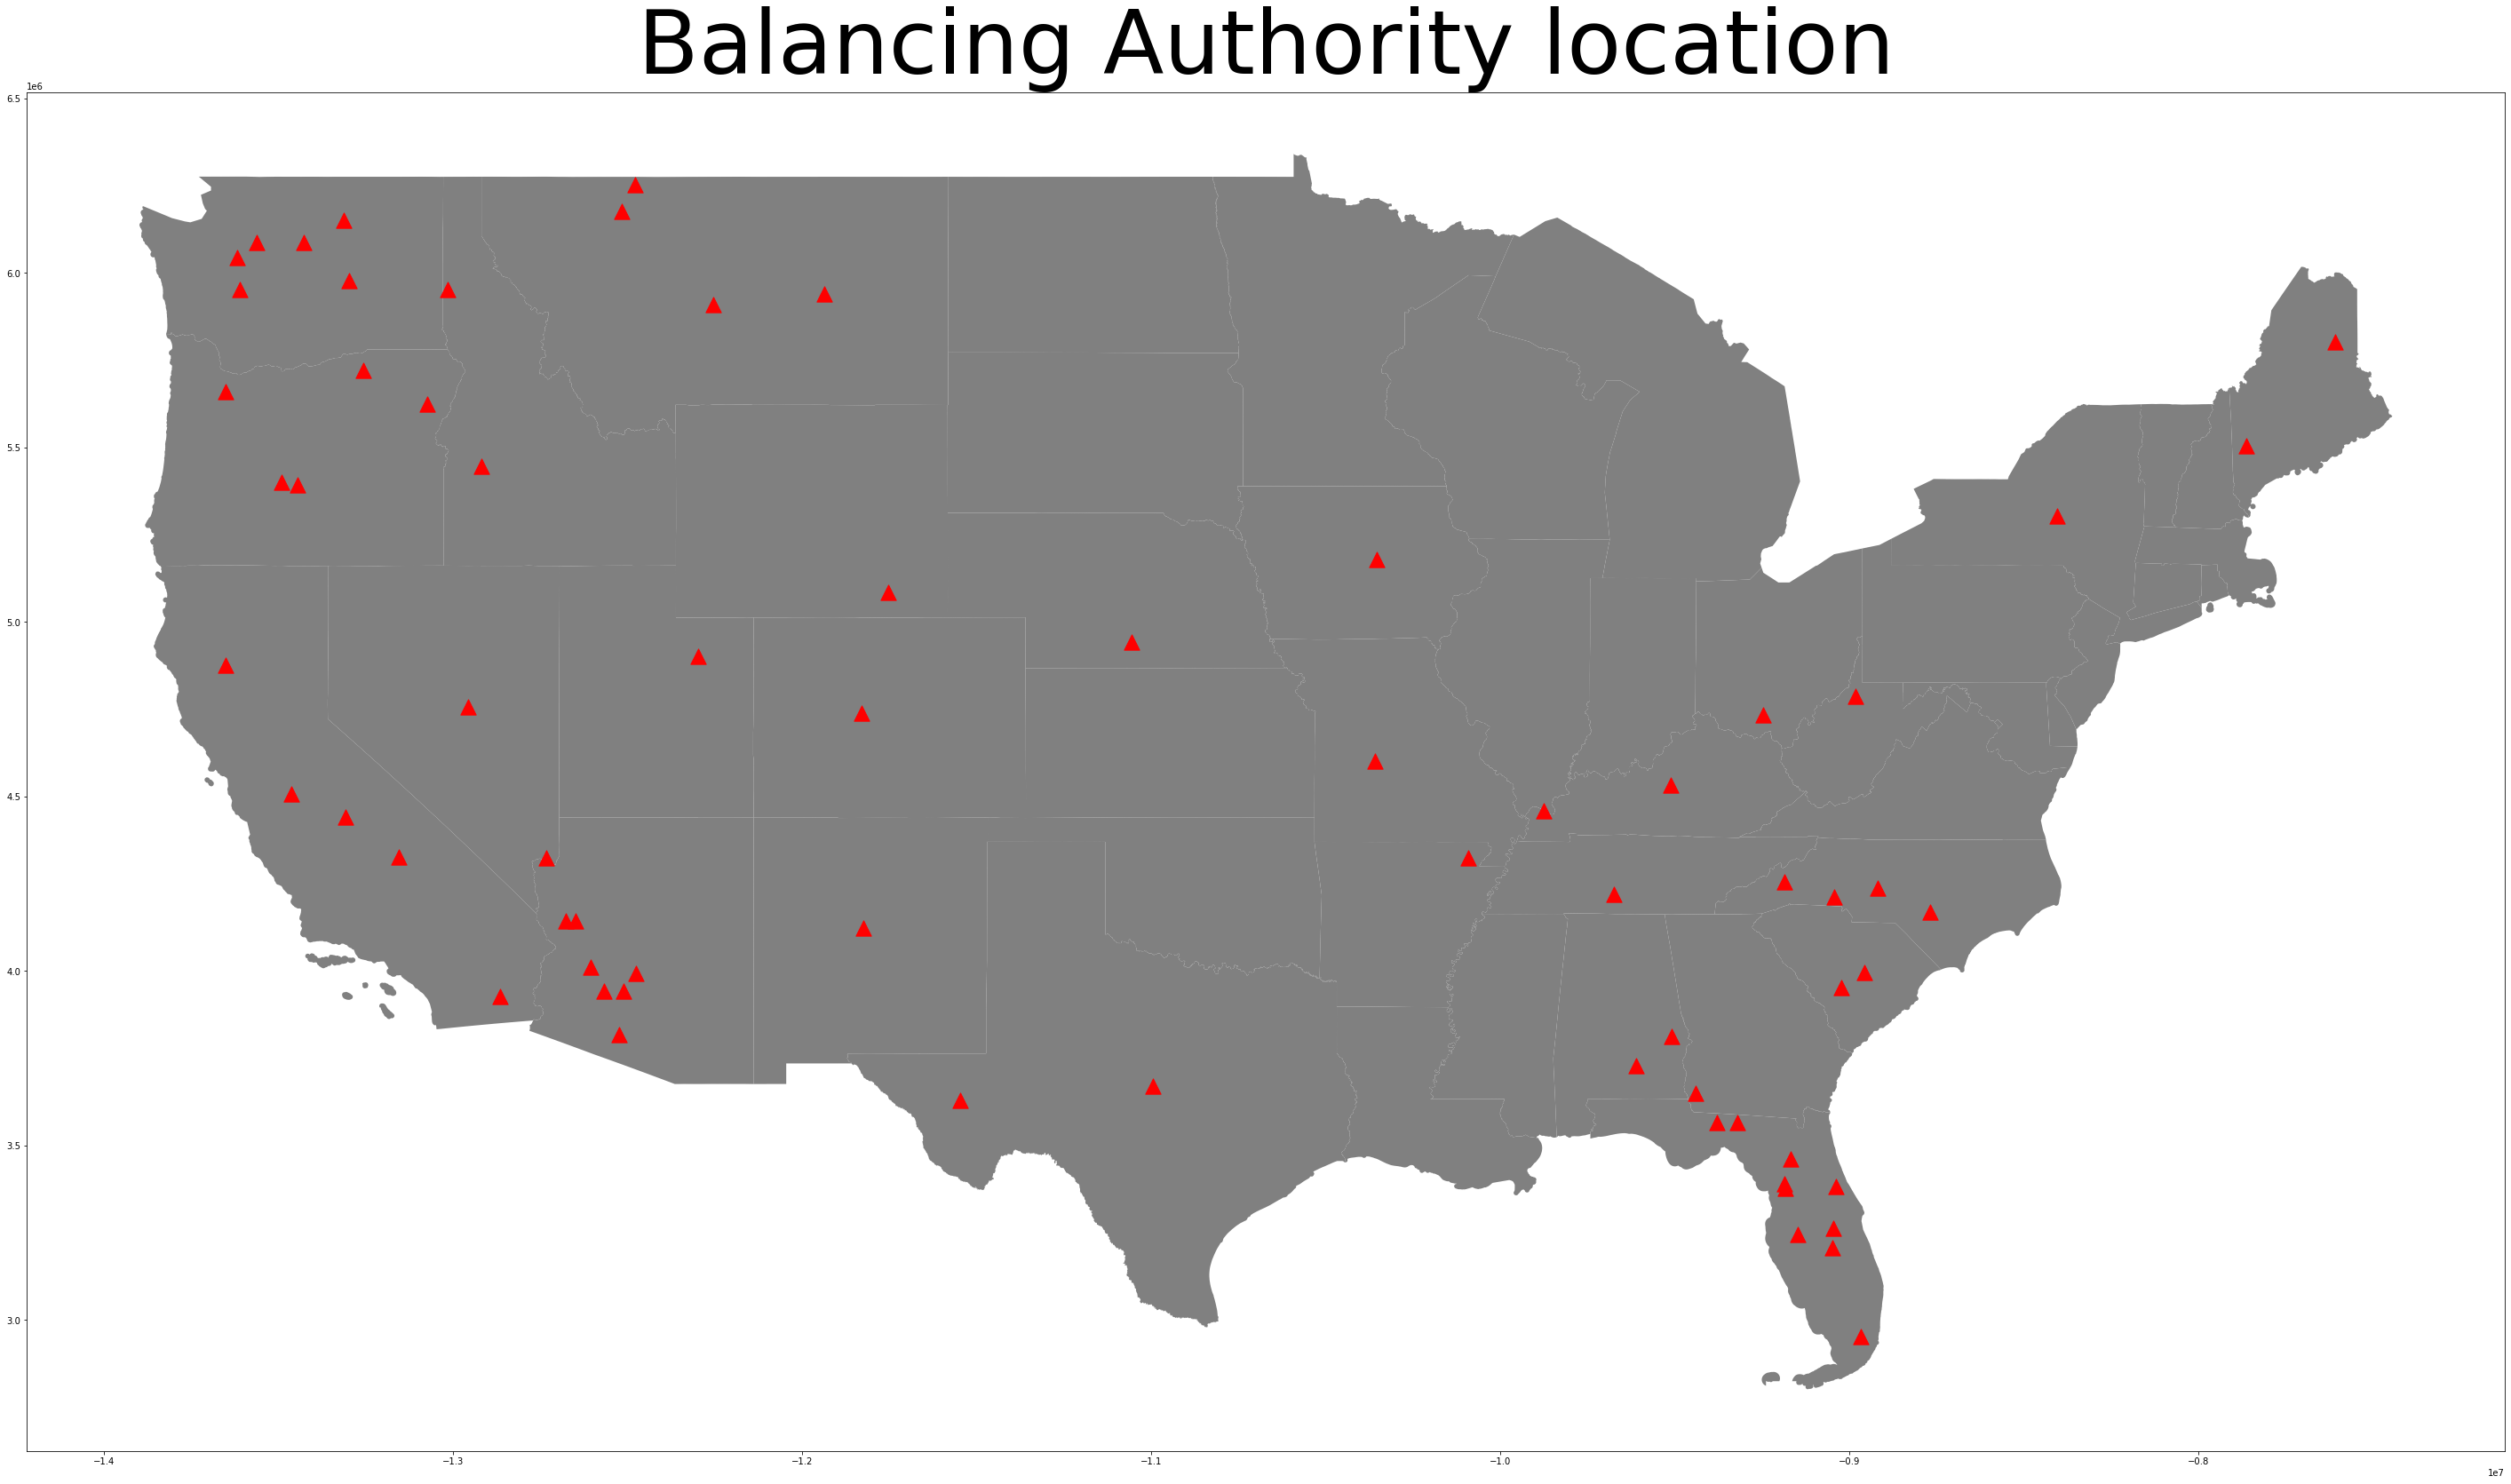

In [41]:
#plot the balancing authority location over US map
fig, ax = plt.subplots(figsize=(50,50))

usa_state.loc[(usa_state['NAME'] != 'Hawaii') & (usa_state['NAME'] != 'Alaska') & (usa_state['REGION'] != '9')].plot(ax=ax,color='grey')

BA_Acronyms_3857.plot(column='BA Code', ax=ax, legend=True, markersize=300,marker='^',color='red')
plt.title('Balancing Authority location',size=100)
plt.show()

In [42]:
#set the relation data to G
import networkx as nx
G = nx.from_pandas_edgelist(transferData_2018,source = 'origin', target = 'destination',edge_attr = 'monthlyTransferMWh')

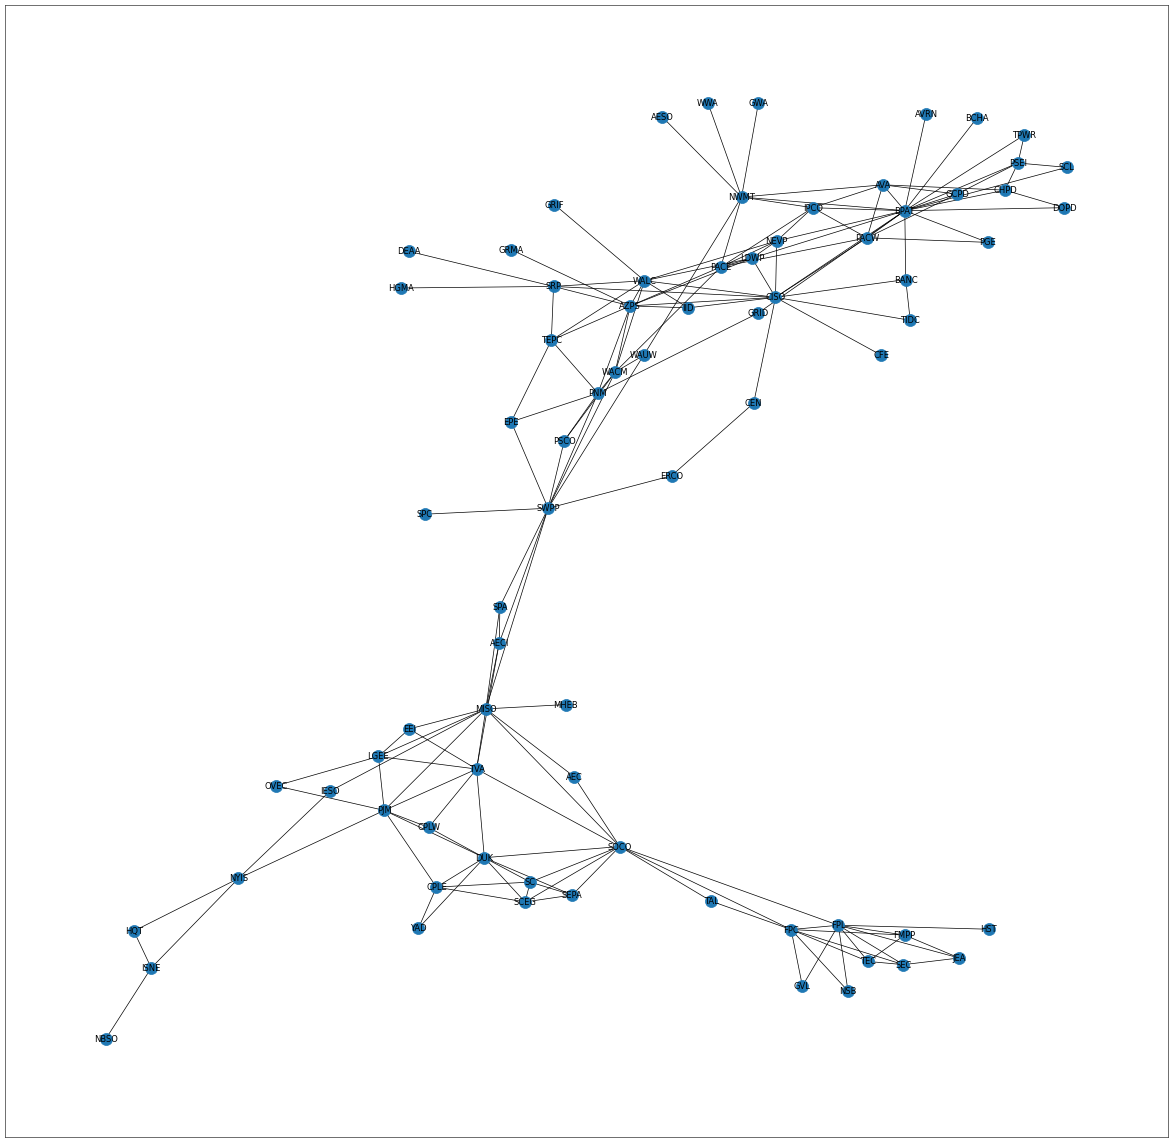

In [43]:
#method 1 networkX
# all graph options
graphs_viz_options = [nx.draw, nx.draw_networkx, nx.draw_circular, nx.draw_kamada_kawai, nx.draw_random, nx.draw_shell, nx.draw_spring]

# plot graph option, can change from 0 to 6 to choose differernt plotting methods
selected_graph_option = 1
# plot
plt.figure(figsize=(30,30), dpi=50) 
graphs_viz_options[selected_graph_option](G)

In [58]:
#method 2
from pyvis.network import Network
#create vis network
net = Network(notebook = True)
#load the networkx graph
net.from_nx(G)
#show
net.show("example.html")
#the graph can be dragged to show the relationships between points

### Data Preparation Visualization 2: Emissions and Location Dataframe 

- Merge plant-level emissions data with plant location data

In [18]:
# Merge with plant-level GHG Emissions data with plant location data
fuelAndGeneration_2018_location =  pd.merge(fuelAndGeneration_2018_AggPlant,
                                                plantData_2018, 
                                                left_on=['Plant ID'], 
                                                right_on=['Plant Code'],
                                                how = 'left',
                                                suffixes =  ('', '_2'))
fuelAndGeneration_2018_location = fuelAndGeneration_2018_location[['Month', 'Plant ID', 'Latitude', 'Longitude', 'Balancing Authority Code',
                                                                           'GHG Estimate (lbs)', 'Net Generation (MWh)']] 
fuelAndGeneration_2018_location = fuelAndGeneration_2018_location[fuelAndGeneration_2018_location['Net Generation (MWh)'] > 0]
#fuelAndGeneration_2018_location.to_csv('fuelAndGeneration_2018_location.csv')
fuelAndGeneration_2018_location.head()

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh)
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0


## Visualization 2:  Map of Point Source GHG Emissions

- How are greenhouse gases spatially emitted by electricty generation in the U.S.?

### Data Preparation Visualization 3: Emissions and Fuel Type Dataframe 

- Determine the primary fuel(s) used for each power plant
    - Aggregate various coal types together
    - By mass, most emissions come from coal and nattural gas

In [19]:
# Create a function to convert the codes of different coal type to a standard 'COAL'
def coal(fuelType):
    COAL_CODES = ['ANT','BIT','LIG','SUB','RC','WC']
    
    if fuelType in COAL_CODES:
        fuelType = 'COAL'
    
    return fuelType

In [20]:
# Convert the codes of different coal types to 'COAL'
fuelAndGeneration_2018long_Coal = fuelAndGeneration_2018long.copy()
fuelAndGeneration_2018long_Coal['Reported Fuel Type Code'] = fuelAndGeneration_2018long.apply(lambda row: coal(row['Reported Fuel Type Code']),axis=1)
#fuelAndGeneration_2018long_Coal

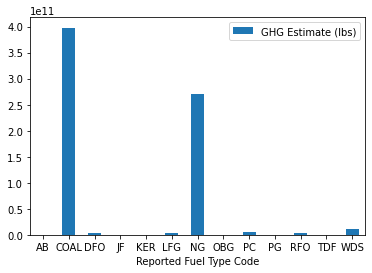

In [21]:
# Aggregate GHG Emissions by fuel type
emissions_byAllFuel_2018_Agg = fuelAndGeneration_2018long_Coal.groupby(by = ['Reported Fuel Type Code'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                         'Net Generation (MWh)': ['sum']})

emissions_byAllFuel_2018_Agg.columns = emissions_byAllFuel_2018_Agg.columns.droplevel(1)
emissions_byAllFuel_2018_Agg['GHG emissions (lbs/MWh)'] = emissions_byAllFuel_2018_Agg['GHG Estimate (lbs)'] / emissions_byAllFuel_2018_Agg['Net Generation (MWh)']
ax = emissions_byAllFuel_2018_Agg.plot.bar(x='Reported Fuel Type Code', y='GHG Estimate (lbs)', rot=0)
#ax = emissions_byAllFuel_2018_Agg.plot.bar(x='Reported Fuel Type Code', y='GHG emissions (lbs/MWh)', rot=0)

#### Table 1: Fuel Type Codes

| Fuel Code | Fuel |
| ---       | ---  |
| AB | Agricultural By-Products |
| COAL | Coal |
| DFO | Distillate Fuel Oil |
| JF | Jet Fuel |
| KER | Kerosene |
| LFG | Landfill Gas |
| NG | Natural Gas |
| OBG | Other Biomass Gas |
| PC | Petroleum Coke |
| PG | Propane Gas |
| RFO | Residual Fuel Oil |
| TDF | Tire-Derived Fuels |
| WDS | Wood/Wood Waste Solids |


In [22]:
# Aggregate generation and emissions by plant and fuel type
fuelAndGeneration_2018_AggFuel = fuelAndGeneration_2018long_Coal.groupby(by = ['Month','Plant ID','Reported Fuel Type Code'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                                              'Net Generation (MWh)': ['sum']})

fuelAndGeneration_2018_AggFuel.columns = fuelAndGeneration_2018_AggFuel.columns.droplevel(1)

# Keep emissions above a given threshold to get rid of secondary fuels
emissions_threshold3 = fuelAndGeneration_2018_AggFuel['GHG Estimate (lbs)'].quantile(.25)

fuelAndGeneration_2018_AggFuel_quantile = fuelAndGeneration_2018_AggFuel[fuelAndGeneration_2018_AggFuel['GHG Estimate (lbs)'] > emissions_threshold3]
#fuelAndGeneration_2018_AggFuel_quantile

# Keep emissions only for NG and Coal
fuelAndGeneration_2018_AggFuel_CoalNG = fuelAndGeneration_2018_AggFuel[fuelAndGeneration_2018_AggFuel['Reported Fuel Type Code'].isin(['NG','COAL']) ]
#fuelAndGeneration_2018_AggFuel_CoalNG

In [23]:
# Find the primary fuels for each plant

# What percentage of total plant generation is each fuel type responsible for?
fuelType_AggPlant =  pd.merge(fuelAndGeneration_2018_AggFuel_CoalNG,
                              fuelAndGeneration_2018_AggPlant,
                              left_on=['Plant ID','Month'], 
                              right_on=['Plant ID','Month'],
                              how = 'left',
                              suffixes =  ('', '_2'))

fuelType_AggPlant = fuelType_AggPlant[['Month','Plant ID', 'Reported Fuel Type Code', 
                                       'Net Generation (MWh)','Net Generation (MWh)_2']] 
#Keep fuels with generation greater than 0
fuelType_AggPlant = fuelType_AggPlant[fuelType_AggPlant['Net Generation (MWh)'] > 0] 
#Keep fuels that are more than 45% of total plant generation
fuelType_AggPlant = fuelType_AggPlant[(fuelType_AggPlant['Net Generation (MWh)'] / fuelType_AggPlant['Net Generation (MWh)_2']) > 0.30]
fuelType_AggPlant['% gen'] = (fuelType_AggPlant['Net Generation (MWh)'] / fuelType_AggPlant['Net Generation (MWh)_2']) * 100
#fuelType_AggPlant.to_csv('fuelType_AggPlant.csv')
#fuelType_AggPlant

In [24]:
# Create function for aggregting to a single fuel type
def aggFuelType(x):
    unique = []
    
    for val in x:
        if val not in unique:
            unique.append(val)
            
    unique.sort()
    
    if len(unique) == 1:
        unique = unique[0] 
    elif unique == ['COAL','NG']:
        unique = 'COAL_NG'
    else:
        unique = tuple(unique)
        
    return unique

In [25]:
#Aggregate by plant to find primary fuel type(s)
fuelType_AggPlant2 = fuelType_AggPlant.groupby(by = ['Plant ID','Month'],as_index=False).agg( {'Reported Fuel Type Code': [aggFuelType]})

fuelType_AggPlant2.columns = fuelType_AggPlant2.columns.droplevel(1)
#fuelType_AggPlant2['Reported Fuel Type Code'].value_counts()


In [26]:
# Merge plant emissions with fuel type
emissions_primaryFuelType =  pd.merge(fuelAndGeneration_2018_location,
                                        fuelType_AggPlant2, 
                                        left_on=['Plant ID','Month'], 
                                        right_on=['Plant ID','Month'],
                                        how = 'left',
                                        suffixes =  ('', '_2'))

emissions_primaryFuelType = emissions_primaryFuelType.dropna()
#emissions_primaryFuelType.to_csv('emissions_primaryFuelType.csv')
emissions_primaryFuelType.head()

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh),Reported Fuel Type Code
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0,COAL_NG
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0,NG
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0,COAL
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0,NG
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0,NG


### Data Preparation Visualization 3: Census Data Preparation

- Import median houshold income by census tract
- Import census tract shapefiles
- Merge income data with geometric data

In [51]:
# Import median household income by census tract
medianIncome_2018 = pd.read_csv('./Income Data/Median Income by Census Tract.csv',header=1)
medianIncome_2018 = medianIncome_2018[['id', 'Estimate!!Households!!Median income (dollars)']]
medianIncome_2018['GEOID'] = medianIncome_2018['id'].str.split('US', 1, expand=True)[1]
medianIncome_2018 = medianIncome_2018.rename(columns = {'Estimate!!Households!!Median income (dollars)': 'Median income (dollars)'})
medianIncome_2018 = medianIncome_2018[['GEOID', 'Median income (dollars)']]
medianIncome_2018.head()

,GEOID,Median income (dollars)
0,01001020100,58625
1,01001020200,43531
2,01001020300,51875
3,01001020400,54050
4,01001020500,72417


,GEOID,geometry
0,01087232100,"POLYGON ((-85.73401 32.40810, -85.73390 32.408..."
1,01101002201,"POLYGON ((-86.31642 32.34430, -86.31624 32.344..."
2,01101002202,"POLYGON ((-86.31681 32.32241, -86.31599 32.322..."
3,01101002300,"POLYGON ((-86.33477 32.32758, -86.33457 32.328..."
4,01101002400,"POLYGON ((-86.34781 32.32959, -86.34670 32.332..."


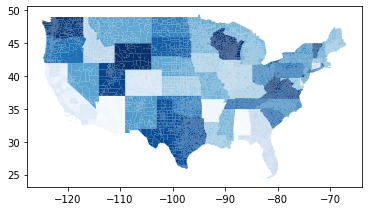

In [54]:
# Import U.S. census tract shapefiles
censusTract_stateIDs = list(range(1,57))
removeVals = [3, 7, 14, 43, 52] # not US state or DC
nonContiguous = [2,15] # [Hawaii, Alaska]
censusTract_stateIDs = [i for i in censusTract_stateIDs if i not in removeVals]
censusTract_stateIDs_contiguous = [i for i in censusTract_stateIDs if i not in nonContiguous]

for n in censusTract_stateIDs_contiguous:
    if n < 10:
        tractID = '0'+str(n)
    else:
        tractID = str(n)
    
    tract_temp = gpd.read_file(f'./censusTracts_2018/tl_2018_{tractID}_tract/tl_2018_{tractID}_tract.shp')
    tract_temp = tract_temp[['GEOID','geometry']]
        
    if n == 1:
        US_tracts = tract_temp.copy()
    else:
        frames = [US_tracts,tract_temp]
        US_tracts = pd.concat(frames, sort=False)
       
US_tracts.plot("GEOID", cmap="Blues")  
US_tracts.head()

In [56]:
# Merge Income data and tract geometry
incomeData_tractGeometry = US_tracts.merge(medianIncome_2018,
                                      left_on="GEOID",
                                      right_on='GEOID',
                                      how = 'left')
incomeData_tractGeometry.head()

,GEOID,geometry,Median income (dollars)
0,01087232100,"POLYGON ((-85.73401 32.40810, -85.73390 32.408...",37098
1,01101002201,"POLYGON ((-86.31642 32.34430, -86.31624 32.344...",26829
2,01101002202,"POLYGON ((-86.31681 32.32241, -86.31599 32.322...",31276
3,01101002300,"POLYGON ((-86.33477 32.32758, -86.33457 32.328...",26553
4,01101002400,"POLYGON ((-86.34781 32.32959, -86.34670 32.332...",29250


## Visualization 3:  Map of Power Plants & Fuel Type and Median Household Income

- What is the relationship between power plants (and subsequently emissions and pollution) and wealth?

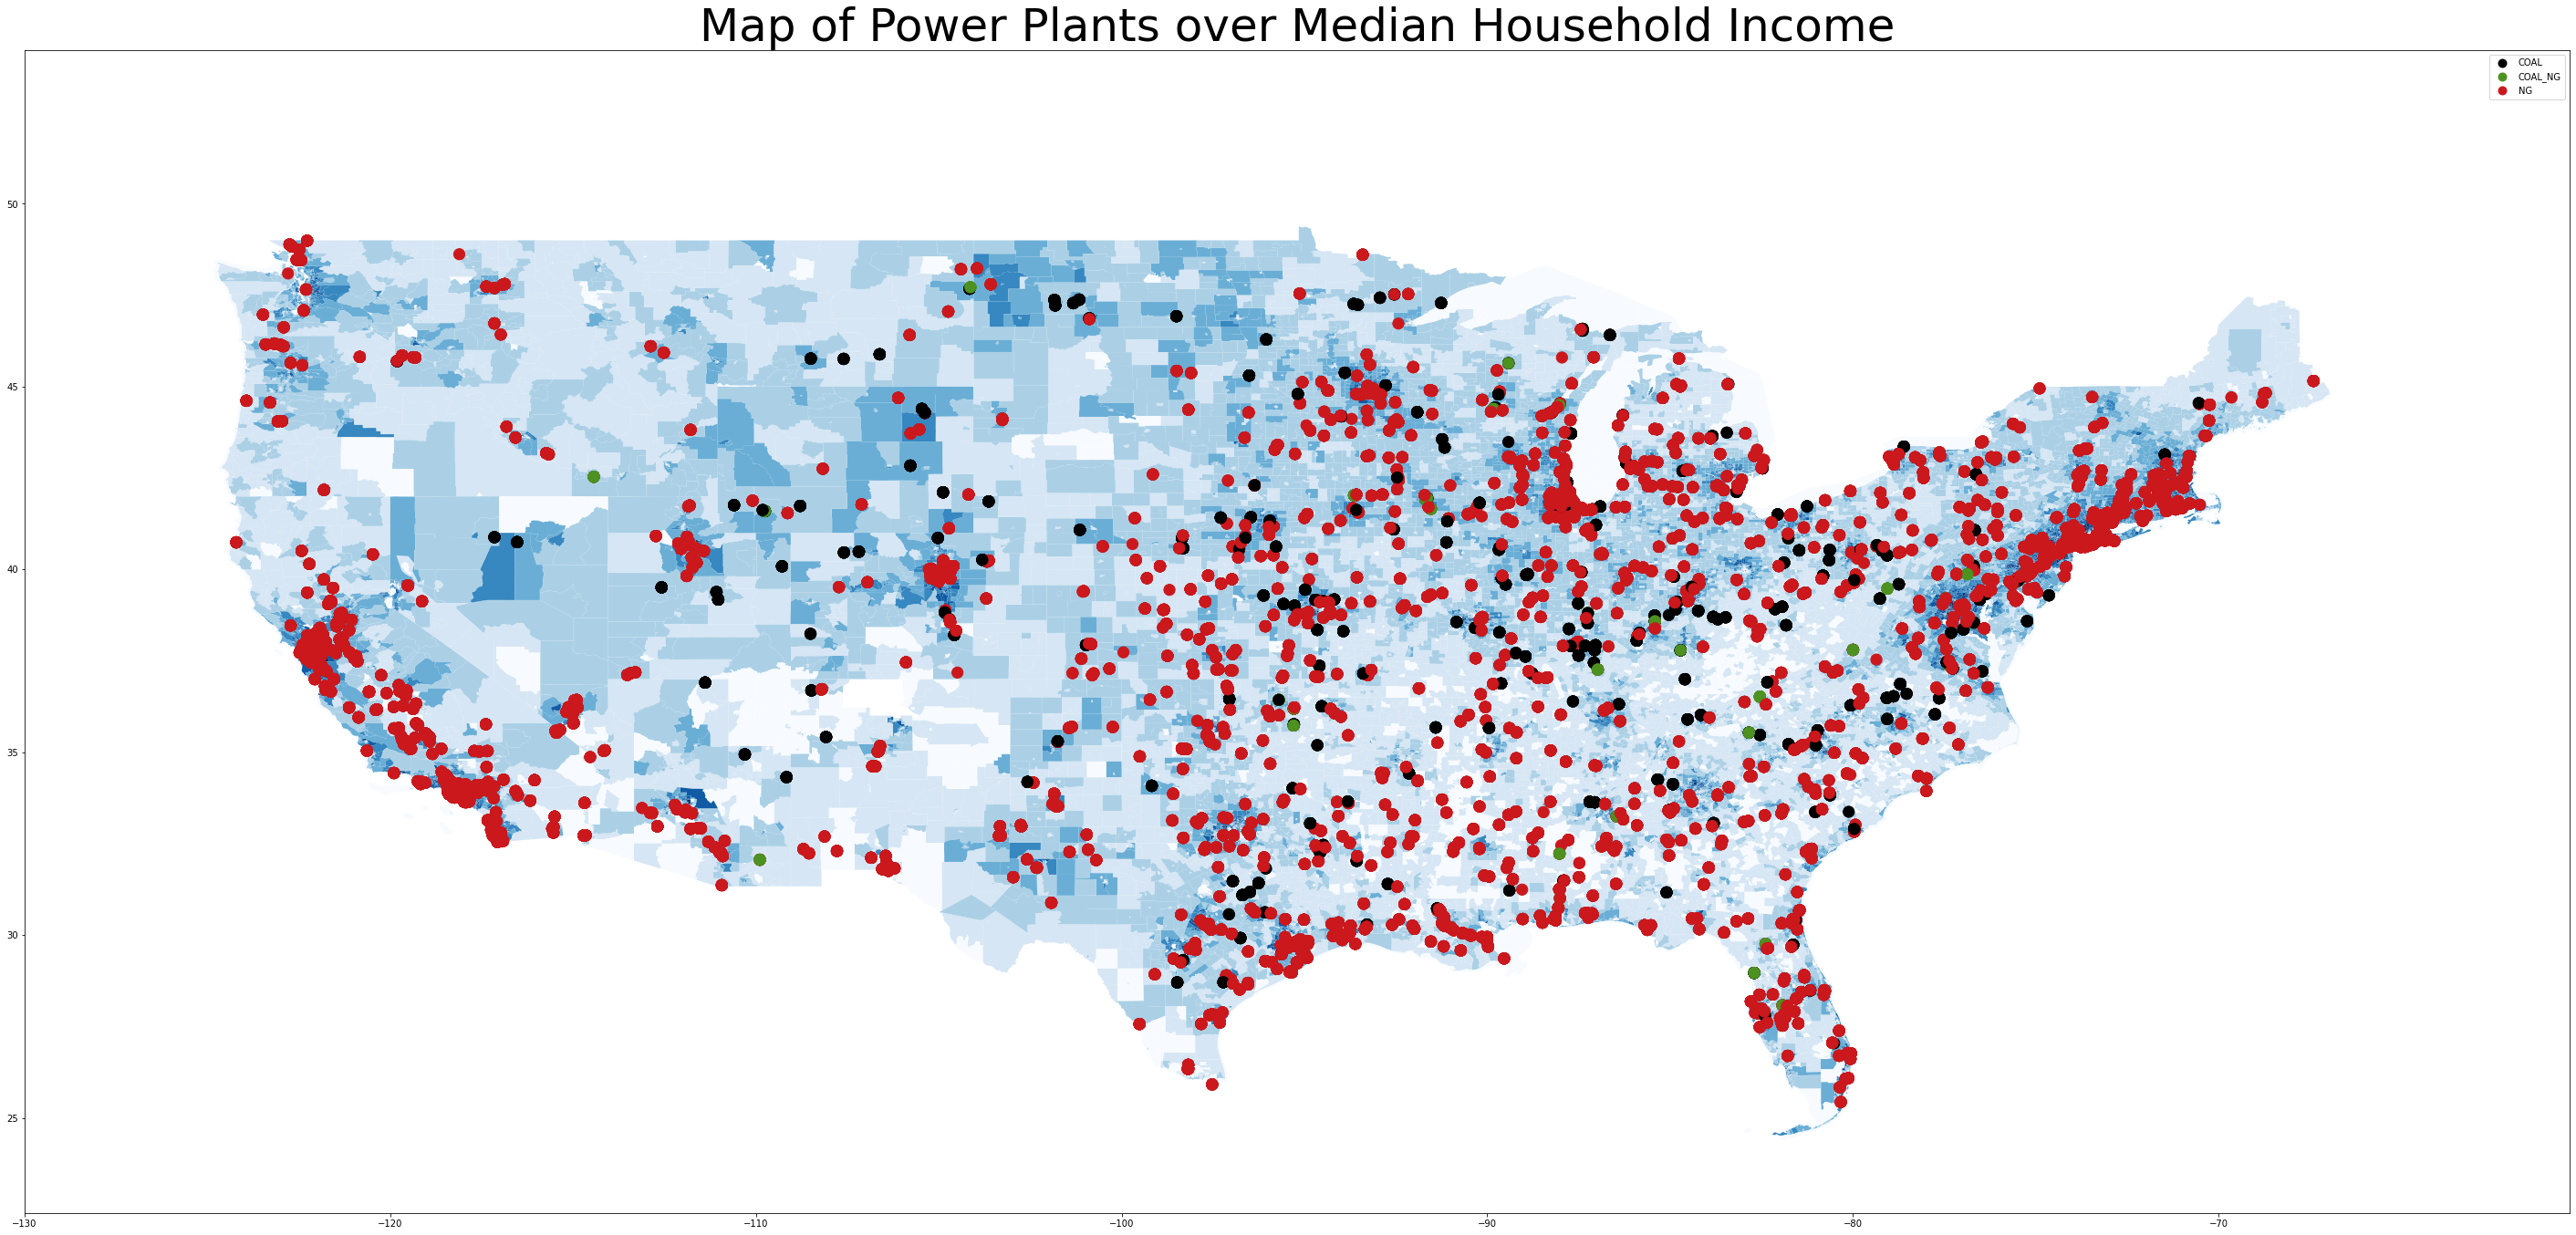

In [57]:
# Change string values to values that can be changed to floats
incomeData_tractGeometry['Median income (dollars)'] = incomeData_tractGeometry['Median income (dollars)'].replace(['-', '250,000+', '2,500-'],['0', '250000', '2500'])
# Change all values to floats so natural breaks can classify
incomeData_tractGeometry['Median income (dollars)'] = [float(i) for i in incomeData_tractGeometry['Median income (dollars)']] 
# Change income tract data to World Mercator system
incomeData_tractGeometry.to_crs("EPSG:3395")
# Create figure and set figure limits
fig,ax = plt.subplots(figsize=(50,50))
ax.set_ylim([22.4, 54.2])
ax.set_xlim([-130.0, -60.4])
ax.set_title('Map of Power Plants over Median Household Income', fontsize=50)
# Plot choropleth map of median household income data
incomeData_tractGeometry.plot(ax=ax, cmap='Blues', column='Median income (dollars)',
                              legend=True, k=7, scheme='NaturalBreaks')
colors = ['#000000', '#4d9221', '#cb181d']
cmap = LinearSegmentedColormap.from_list('cm', colors, N=3)
# Create geodataframe from pandas dataframe
emissions = gpd.GeoDataFrame(emissions_primaryFuelType,
                            geometry=gpd.points_from_xy(emissions_primaryFuelType.Longitude,
                                                        emissions_primaryFuelType.Latitude)) 
# Set emissions coordinate system to World Mercator
emissions.set_crs("EPSG:3395")
# Plot locations of power plants over income data
emissions.plot(ax=ax, column='Reported Fuel Type Code', legend=True, cmap=cmap, markersize=150)
plt.show()

In [49]:
from IPython.display import Image

#Image(filename='./Map_of_Power_Plants_over_Income.png') 

### Project Roles

- **Jenni Nugent**:  Data cleaning and preparation
- **Guangyu Cai**:   Visualization 1
- **Amina Jackson**: Visualization 2
- **Joe Franke**:    Visualization 3